# Text detection with EAST

- Original paper: https://arxiv.org/pdf/1704.03155v2.pdf

# Importing the libraries

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# PyImageSearch packages for image processing utilities
from imutils.object_detection import non_max_suppression

#from google.colab.patches import cv2_imshow
def cv2_imshow(img, to_rgb=True):
    if to_rgb:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR -> RGB
    plt.imshow(img)
    plt.show()

# Connecting to Google Drive

In [13]:
#from google.colab import drive
#drive.mount('/content/drive')

In [14]:
#!cp /content/drive/MyDrive/Cursos\ -\ recursos/OCR\ with\ Python/Models/frozen_east_text_detection.pb ./

In [15]:
#!cp -R /content/drive/MyDrive/Cursos\ -\ recursos/OCR\ with\ Python/Images images/

In [16]:
DATAPATH = "../../material/"

# Pre-processing the image

In [59]:
# EAST is a FCN which detects regions wich might likely contain text.
# It works robustly with natural scenes.
# We obtain a score map and candidate bouding boxes set in the map
# Then, we need to apply non-maximum supression (NMS) to narrow down the bboxes.
detector = DATAPATH+'Models/frozen_east_text_detection.pb'
# We need to resize the image to the input size of the neural network
# EAST works with sizes which are multiples of 320
width, height = 320, 320
image = DATAPATH+'Images/cup.jpg'
# Minimum confidence for our text bboxes.
min_confidence = 0.9

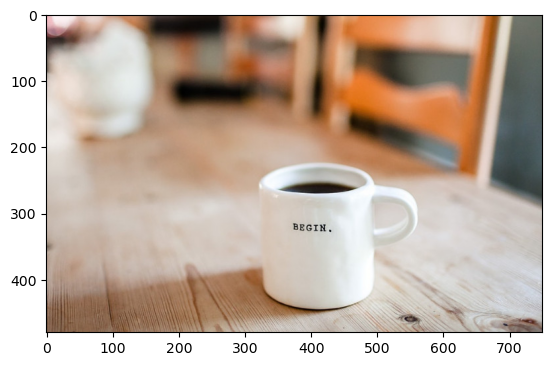

In [60]:
img = cv2.imread(image)
cv2_imshow(img)

In [62]:
# Since we resize, the image, we keep a copy of the org
original = img.copy()

In [63]:
img.shape

(480, 750, 3)

In [64]:
H = img.shape[0]
W = img.shape[1]
print(H, W)

480 750


In [66]:
# Save propostions/ratios to draw/display properly later only
proportion_W = W / float(width)
proportion_H = H / float(height)
print(proportion_W, proportion_H)

2.34375 1.5


In [67]:
img = cv2.resize(img, (width, height))
H = img.shape[0]
W = img.shape[1]
print(H, W)

320 320


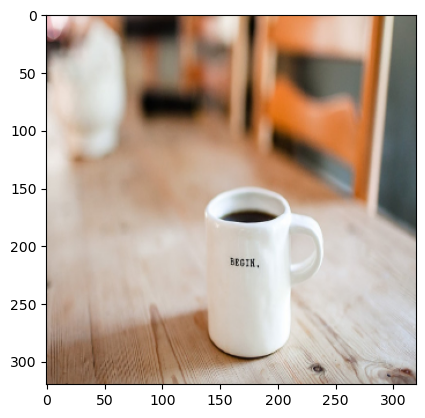

In [24]:
cv2_imshow(img)

# Loading the neural network

![EAST Architecture](../../assets/EAST_architecture.jpg)

In [25]:
# We create a list with layer names
# that refer to the score map (Sigmoid) and the bounding boxes (concat_3)
layers_names = ['feature_fusion/Conv_7/Sigmoid', 'feature_fusion/concat_3']

In [26]:
# Load the detector network
neural_network = cv2.dnn.readNet(detector)

In [27]:
# Resized CV2 image (array)
img.shape

(320, 320, 3)

In [70]:
# Convert image array to a BLOB type
blob = cv2.dnn.blobFromImage(img,
                             scalefactor=1.0,
                             size=(W, H),
                             swapRB=True,
                             crop=False)

In [71]:
blob.shape # batch size

(1, 3, 320, 320)

In [76]:
# Input the BLOB/image
neural_network.setInput(blob)
# Get the output: for that we need to spcify the output layers
scores, geometry = neural_network.forward(layers_names)

In [78]:
# We get a 80x80 map with scores/confidences
scores.shape

(1, 1, 80, 80)

In [80]:
# Each cell in the 80x80 map has a bbox associated
geometry.shape

(1, 5, 80, 80)

In [81]:
scores

array([[[[1.4775182e-07, 5.3355319e-07, 6.1831184e-07, ...,
          2.3887444e-06, 2.1422467e-07, 1.9741565e-06],
         [2.2155250e-07, 8.2297476e-08, 1.5269325e-07, ...,
          3.8021703e-06, 2.4969086e-07, 2.0974837e-06],
         [2.4107598e-07, 2.5650635e-07, 6.7496660e-07, ...,
          4.4842463e-06, 6.0891395e-08, 2.5159140e-06],
         ...,
         [5.1903379e-07, 1.3470776e-07, 3.8078852e-08, ...,
          1.7954445e-06, 7.7535697e-07, 5.4700799e-06],
         [2.8565944e-07, 8.5580240e-08, 1.1289968e-07, ...,
          1.1354857e-06, 9.0157494e-07, 5.0782614e-06],
         [7.2199931e-08, 8.4332985e-09, 5.4603810e-09, ...,
          1.9142344e-07, 3.1659900e-07, 1.0240406e-07]]]], dtype=float32)

In [82]:
geometry

array([[[[ 1.54848877e+02,  1.01938683e+02,  1.08211128e+02, ...,
           1.33965591e+02,  1.27577332e+02,  1.46967987e+02],
         [ 1.19407845e+02,  6.46941986e+01,  7.18581772e+01, ...,
           9.02676010e+01,  8.52865753e+01,  1.03320290e+02],
         [ 1.22548691e+02,  6.90612030e+01,  7.86800232e+01, ...,
           1.06369835e+02,  1.01670227e+02,  1.14973694e+02],
         ...,
         [ 1.16457344e+02,  4.99966621e+01,  3.75176506e+01, ...,
           8.21259613e+01,  8.12640228e+01,  1.21695618e+02],
         [ 1.27623413e+02,  5.88199692e+01,  4.84033051e+01, ...,
           8.31772308e+01,  8.09339676e+01,  1.11183853e+02],
         [ 1.26661499e+02,  7.53629303e+01,  6.93248062e+01, ...,
           1.27025391e+02,  1.18697914e+02,  1.47223694e+02]],

        [[ 1.09559769e+02,  9.52128677e+01,  9.08699341e+01, ...,
           1.00495575e+02,  9.43882065e+01,  1.12618629e+02],
         [ 8.27181091e+01,  5.77866745e+01,  5.62353096e+01, ...,
           6.53349609e

In [83]:
geometry[0,0]

array([[154.84888 , 101.93868 , 108.21113 , ..., 133.96559 , 127.57733 ,
        146.96799 ],
       [119.407845,  64.6942  ,  71.85818 , ...,  90.2676  ,  85.286575,
        103.32029 ],
       [122.54869 ,  69.0612  ,  78.68002 , ..., 106.369835, 101.67023 ,
        114.973694],
       ...,
       [116.457344,  49.996662,  37.51765 , ...,  82.12596 ,  81.26402 ,
        121.69562 ],
       [127.62341 ,  58.81997 ,  48.403305, ...,  83.17723 ,  80.93397 ,
        111.18385 ],
       [126.6615  ,  75.36293 ,  69.32481 , ..., 127.02539 , 118.697914,
        147.2237  ]], dtype=float32)

# Decoding the values

The EAST model takes a 320x320 RGB image (or a multiple of that size) and returns a 80x80 (1) score/confidence map and a (2) map with the bounding box values. The decoding of the bounding boxes is explained in the paper and in [this Stackoverflow post](https://stackoverflow.com/questions/55583306/decoding-geometry-output-of-east-text-detection).
![EAST Bounding Boxes](../../assets/EAST_bboxes.jpg)g)

In [91]:
# Confidences
scores.shape[2:4]

(80, 80)

In [93]:
# Bounding boxes
geometry.shape

(1, 5, 80, 80)

In [88]:
# Get loop ranges
# Note: Y, X = row, column
rows, columns = scores.shape[2:4]
print(rows, columns)

80 80


In [89]:
# Initialize return lists
boxes = []
confidences = []

In [99]:
def geometric_data(geometry, y):
    """Extract the BBox data given a row:
    angles, x0, x1, x2, x3."""
    xData0 = geometry[0, 0, y] # complete rows of lenth 80!
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    angles_data = geometry[0, 4, y]
    
    return angles_data, xData0, xData1, xData2, xData3

In [100]:
def geometric_calculation(x, angles_data, xData0, xData1, xData2, xData3):
    """Given the BBox data in each row,
    get the start-end BBox coordinates.
    """
    (offsetX, offsetY) = (x * 4.0, y * 4.0)
    angle = angles_data[x]
    cos = np.cos(angle)
    sin = np.sin(angle)
    h = xData0[x] + xData2[x]
    w = xData1[x] + xData3[x]
    
    endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
    endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
    
    beginX = int(endX - w)
    beginY = int(endY - h)

    # FIXME: it seems that the code accounts for oriented BBoxes
    # but here the orientation is neglected...
    return beginX, beginY, endX, endY

In [101]:
rows, columns

(80, 80)

In [102]:
scores

array([[[[1.4775182e-07, 5.3355319e-07, 6.1831184e-07, ...,
          2.3887444e-06, 2.1422467e-07, 1.9741565e-06],
         [2.2155250e-07, 8.2297476e-08, 1.5269325e-07, ...,
          3.8021703e-06, 2.4969086e-07, 2.0974837e-06],
         [2.4107598e-07, 2.5650635e-07, 6.7496660e-07, ...,
          4.4842463e-06, 6.0891395e-08, 2.5159140e-06],
         ...,
         [5.1903379e-07, 1.3470776e-07, 3.8078852e-08, ...,
          1.7954445e-06, 7.7535697e-07, 5.4700799e-06],
         [2.8565944e-07, 8.5580240e-08, 1.1289968e-07, ...,
          1.1354857e-06, 9.0157494e-07, 5.0782614e-06],
         [7.2199931e-08, 8.4332985e-09, 5.4603810e-09, ...,
          1.9142344e-07, 3.1659900e-07, 1.0240406e-07]]]], dtype=float32)

In [109]:
# Get loop ranges
# Note: Y, X = row, column
rows, columns = scores.shape[2:4]
print(rows, columns)

# Initialize return lists
boxes = []
confidences = []

for y in range(0, rows):
    data_scores = scores[0, 0, y]
    # Extract data in each row
    angles_data, xData0, xData1, xData2, xData3 = geometric_data(geometry, y)
    for x in range(0, columns):
        if data_scores[x] < min_confidence: # 0.9
            continue
        # For each row, get all bboxes with high confidence
        beginX, beginY, endX, endY = geometric_calculation(x, angles_data, xData0, xData1, xData2, xData3)
        confidences.append(data_scores[x])
        boxes.append((beginX, beginY, endX, endY))

80 80


In [110]:
confidences

[0.9995617,
 0.99982554,
 0.9997718,
 0.9994678,
 0.96625084,
 0.9642098,
 0.9993309,
 0.99968016,
 0.99951243]

In [111]:
# We see that several bounding boxes were detected
# for the same text.
# We need to apply non-maximal supression (NMS)
boxes

[(156, 208, 190, 220),
 (157, 208, 187, 220),
 (157, 208, 186, 220),
 (158, 207, 186, 220),
 (156, 207, 187, 221),
 (157, 207, 188, 220),
 (158, 208, 187, 221),
 (158, 208, 187, 221),
 (157, 208, 188, 221)]

In [112]:
# Non-maximal supression (NMS)
detections = non_max_suppression(np.array(boxes), probs = confidences)

In [113]:
# Final bounding box
detections

array([[157, 208, 187, 220]])

In [114]:
proportion_H, proportion_W

(1.5, 2.34375)

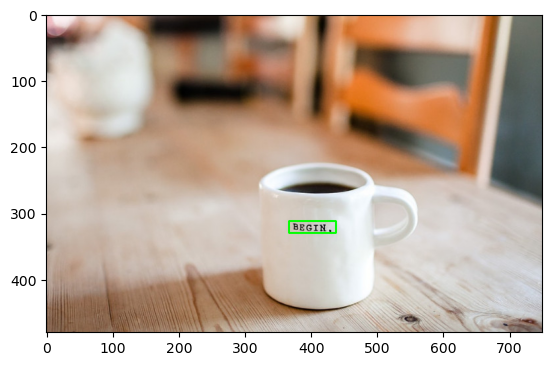

In [118]:
# We need to expand the bounding box to the original image size
# To that end, we used the pre-saved ratios
img_copy = original.copy()
for (beginX, beginY, endX, endY) in detections:
    beginX = int(beginX * proportion_W)
    beginY = int(beginY * proportion_H)
    endX = int(endX * proportion_W)
    endY = int(endY * proportion_H)
    
    # Region of interest
    roi = img_copy[beginY:endY, beginX:endX]
    
    cv2.rectangle(original, (beginX, beginY), (endX, endY), (0,255,0), 2)
cv2_imshow(original)

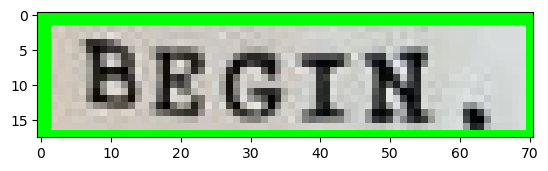

In [119]:
cv2_imshow(roi)

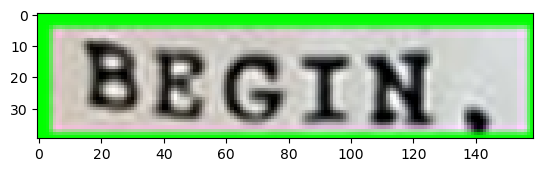

In [121]:
# We increase the size of the ROI by 50%
roi = cv2.resize(roi, None, fx = 1.5, fy = 1.5, interpolation=cv2.INTER_CUBIC)
cv2_imshow(roi)

# Text recognition

In [122]:
#!sudo apt install tesseract-ocr
#!pip install pytesseract 
import pytesseract

In [123]:
#!mkdir tessdata
#!wget -O ./tessdata/por.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true
#!wget -O ./tessdata/eng.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/eng.traineddata?raw=true

In [124]:
!tesseract --help-psm

Page segmentation modes:
  0    Orientation and script detection (OSD) only.
  1    Automatic page segmentation with OSD.
  2    Automatic page segmentation, but no OSD, or OCR. (not implemented)
  3    Fully automatic page segmentation, but no OSD. (Default)
  4    Assume a single column of text of variable sizes.
  5    Assume a single uniform block of vertically aligned text.
  6    Assume a single uniform block of text.
  7    Treat the image as a single text line.
  8    Treat the image as a single word.
  9    Treat the image as a single word in a circle.
 10    Treat the image as a single character.
 11    Sparse text. Find as much text as possible in no particular order.
 12    Sparse text with OSD.
 13    Raw line. Treat the image as a single text line,
       bypassing hacks that are Tesseract-specific.


In [125]:
# Now we recognize the text in each ROI we detected
# Since the ROI has one line we choose PSM 7
# However, note that it is recommendable to expand the ROI some pixels
config_tesseract = "--tessdata-dir tessdata --psm 7"

BEGIN,



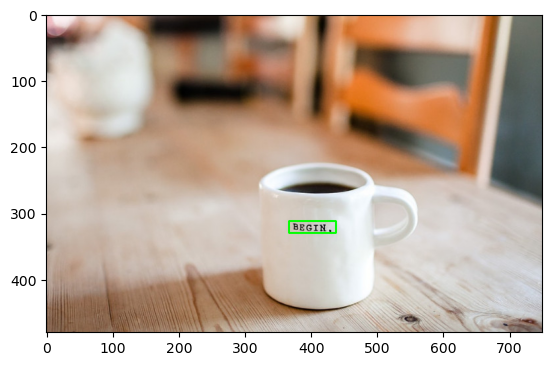

In [126]:
img_copy = original.copy()
for (beginX, beginY, endX, endY) in detections:
    beginX = int(beginX * proportion_W)
    beginY = int(beginY * proportion_H)
    endX = int(endX * proportion_W)
    endY = int(endY * proportion_H)
    
    roi = img_copy[beginY:endY, beginX:endX]
    text = pytesseract.image_to_string(roi, lang = 'eng', config=config_tesseract)
    print(text)
    
    cv2.rectangle(original, (beginX, beginY), (endX, endY), (0,255,0), 2)
cv2_imshow(original)

## Expanding the ROI

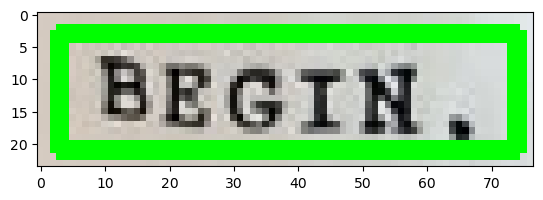

BEGIN,



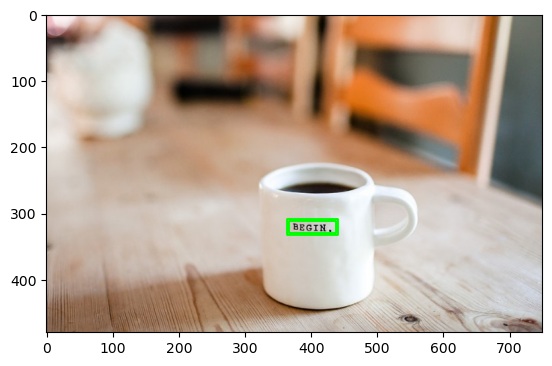

In [127]:
margin = 3
img_copy = original.copy()
for (beginX, beginY, endX, endY) in detections:
    beginX = int(beginX * proportion_W)
    beginY = int(beginY * proportion_H)
    endX = int(endX * proportion_W)
    endY = int(endY * proportion_H)
    
    roi = img_copy[beginY - margin:endY + margin, beginX - margin:endX + margin]
    cv2_imshow(roi)
    text = pytesseract.image_to_string(roi, lang = 'eng', config=config_tesseract)
    print(text)
    
    cv2.rectangle(img_copy, (beginX - margin, beginY - margin), (endX + margin, endY + margin), (0,255,0), 2)
cv2_imshow(img_copy)